# visualise block2vec embeddings, etc.

In [1]:
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
sns.set_theme()

# %matplotlib ipympl
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 100

In [2]:
PRIMARY_OUTPUT_DIR = 'output/block2vec saves/block2vec 64 dim locked air'
OUTPUT_ROOT = 'output/block2vec saves/'
LIST_OUTPUT_FOLDERS = ['block2vec 64 dim' ,'block2vec 64 dim 16 epochs early stop', 'block2vec 32 dim', 'block2vec 64 dim locked air']

## block frequency histogram

this histogram shows the number of each class of blocks seen in the 1977 selected and preprocessed training examples from the Craft-3D dataset. The dataset has a total of _ blocks. The x asis shows the count of each block in logrithmic scale and the y axis indicates the category of each block type

In [3]:
with open(PRIMARY_OUTPUT_DIR + '/block_frequency.pkl', 'rb') as f:
    block_frequency = pickle.load(f)

block_frequency_dict = dict(block_frequency)
block_frequency_keys = list(block_frequency_dict.keys())
block_frequency_vals = [block_frequency_dict[k] for k in block_frequency_keys]
block_frequency_names = [name.replace('minecraft:', '').replace('_', ' ') for name in block_frequency_keys]

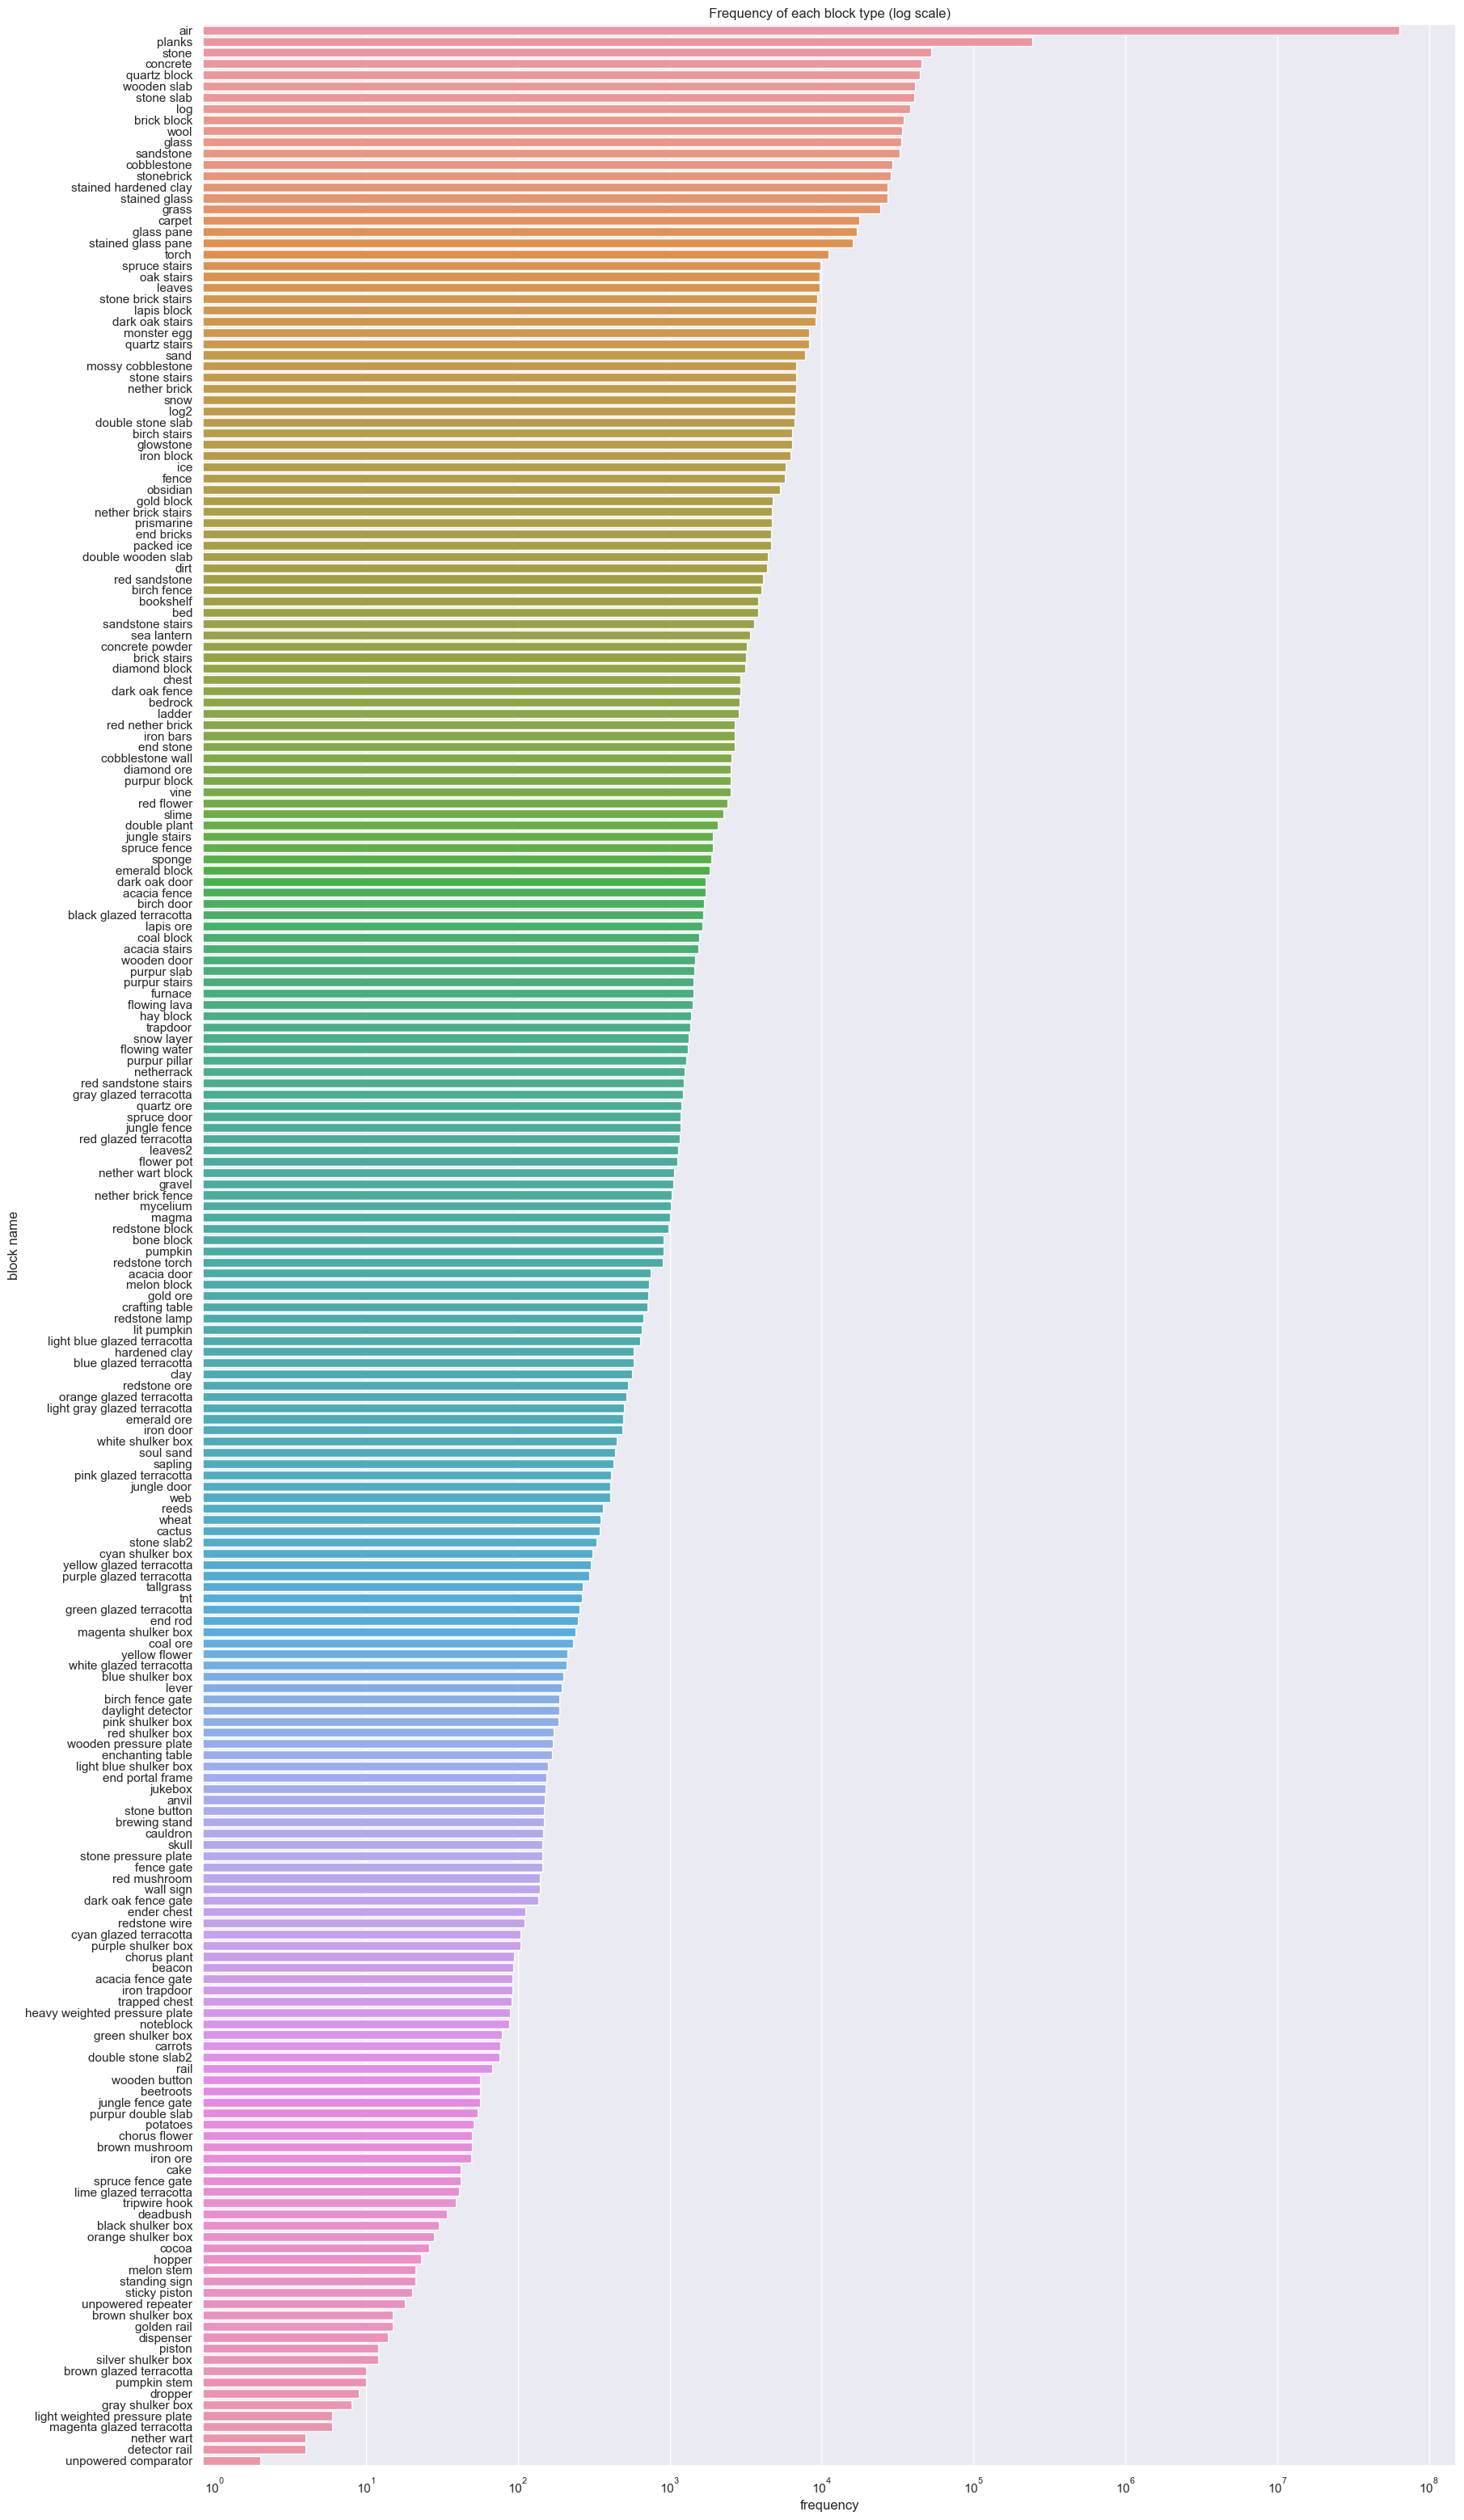

In [4]:
block_frequency_df = pd.DataFrame({'block name': block_frequency_names, 'frequency': block_frequency_vals})
block_frequency_df = block_frequency_df.sort_values('frequency', ascending=False)

plt.figure(figsize=(20, 40))
ax = sns.barplot(x="frequency", y="block name", data=block_frequency_df)
ax.set(xscale="log", title='Frequency of each block type (log scale)')
ax.set_xticks([10 ** power for power in range(9)])
plt.show()

## Embedding

This embedding heatmap visualises the 64-dimensional weights of the vector representing the sementic meaning of the 218 possible tokens used in the experiment. The tokens are arranged on the $x$ axis and the embedding dimensions are displayed on the $y$ axis. The continuous vector representations of tokens enables the NCA model to receive differentiable and thus meaningful results from the discriminator.

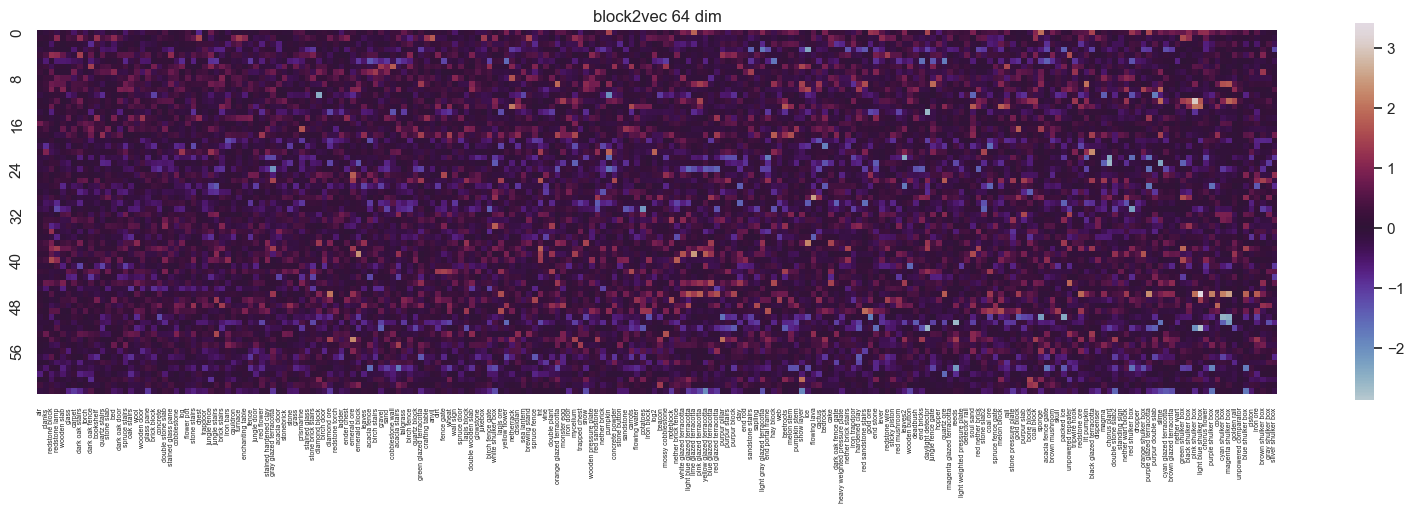

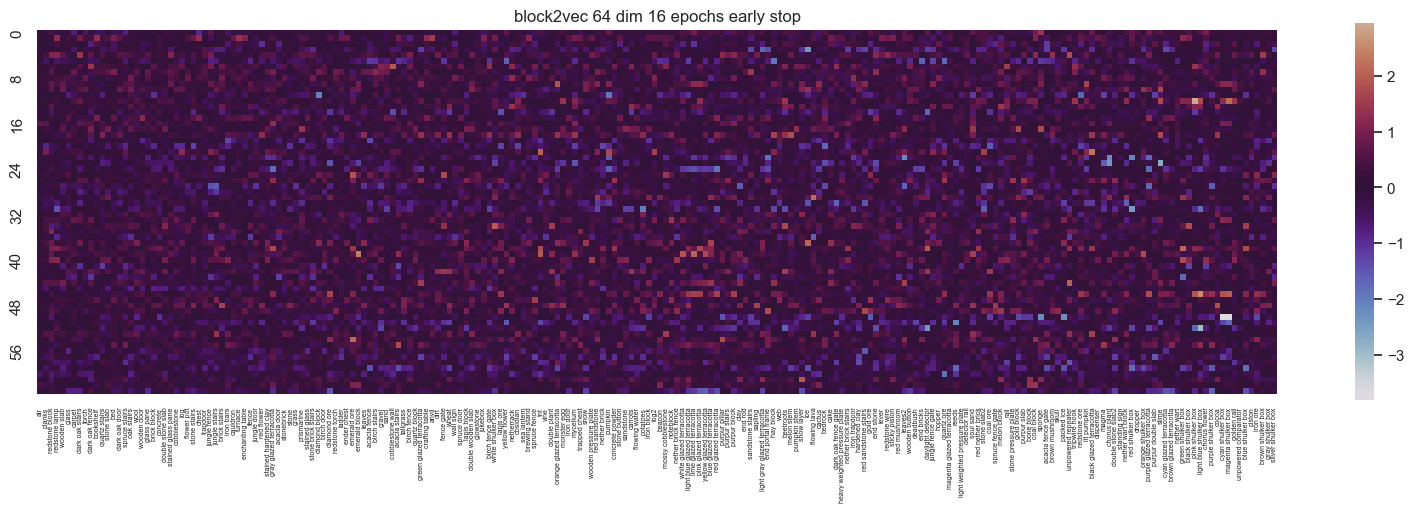

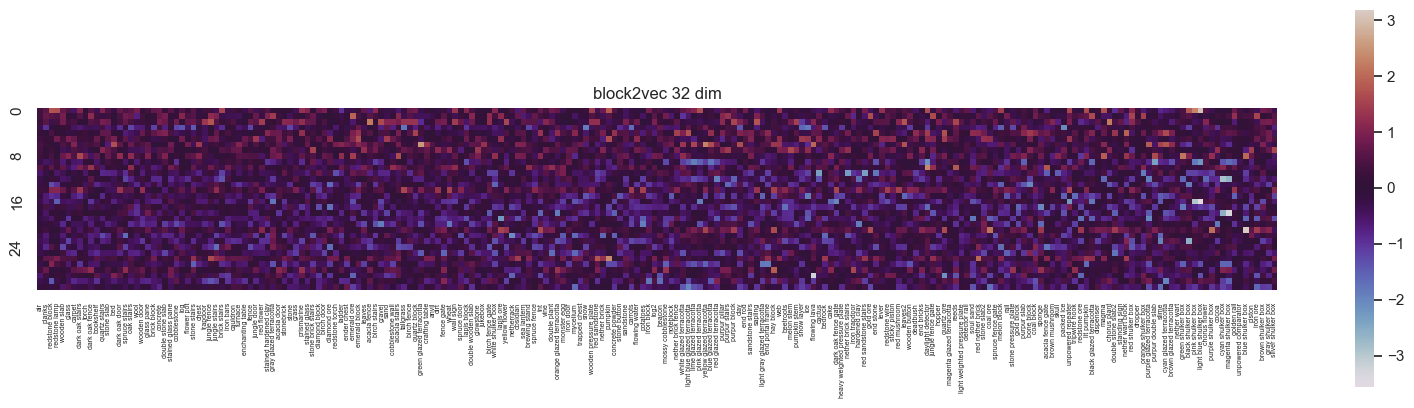

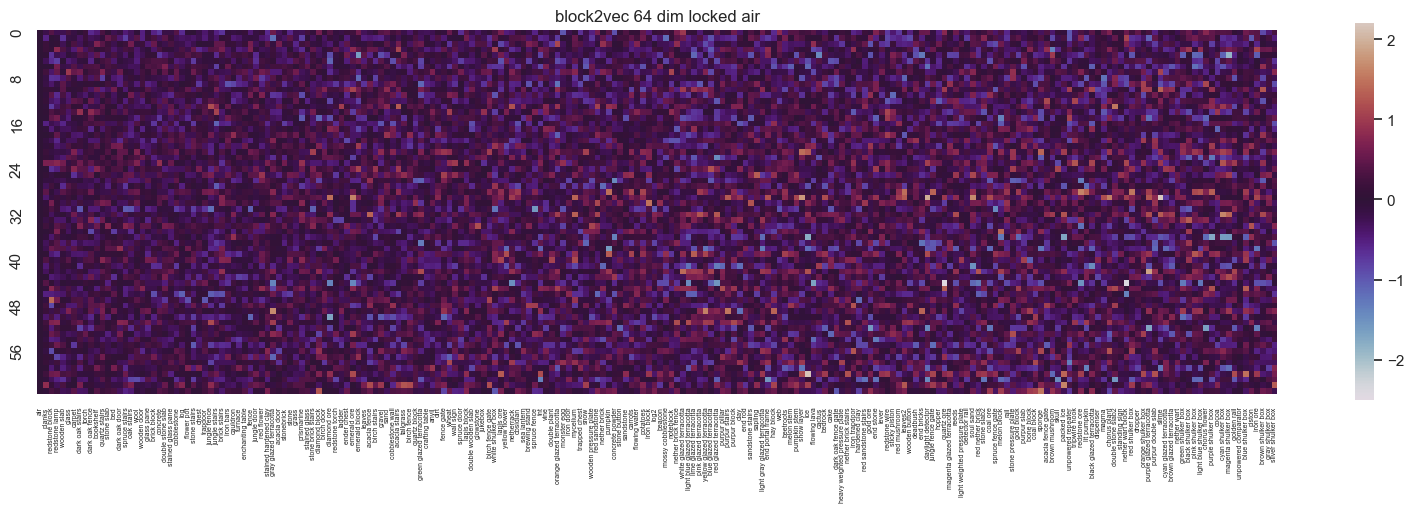

In [5]:
for folder in LIST_OUTPUT_FOLDERS:
    dir = OUTPUT_ROOT + folder
    
    embeddings = np.load(dir + '/embeddings.npy')
    with open(dir + '/block2idx.pkl', 'rb') as f:
        block2idx = dict(pickle.load(f))
    with open(dir + '/idx2block.pkl', 'rb') as f:
        idx2block = dict(pickle.load(f))
    
    f, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(pd.DataFrame(embeddings.transpose()), annot=False, fmt="d", linewidths=0, ax=ax, square=True, xticklabels=list(block2idx.keys()), yticklabels=8, cmap='twilight', center=0)
    xticklabels = [name.replace('minecraft:', '').replace('_', ' ') for name in list(block2idx.keys())]
    ax.set_xticklabels(xticklabels, fontsize=5)
    ax.set_title(folder)
    plt.show()

## Similarity matrix

In [6]:
from torch.nn import functional as F
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sklearn.metrics import mean_squared_error

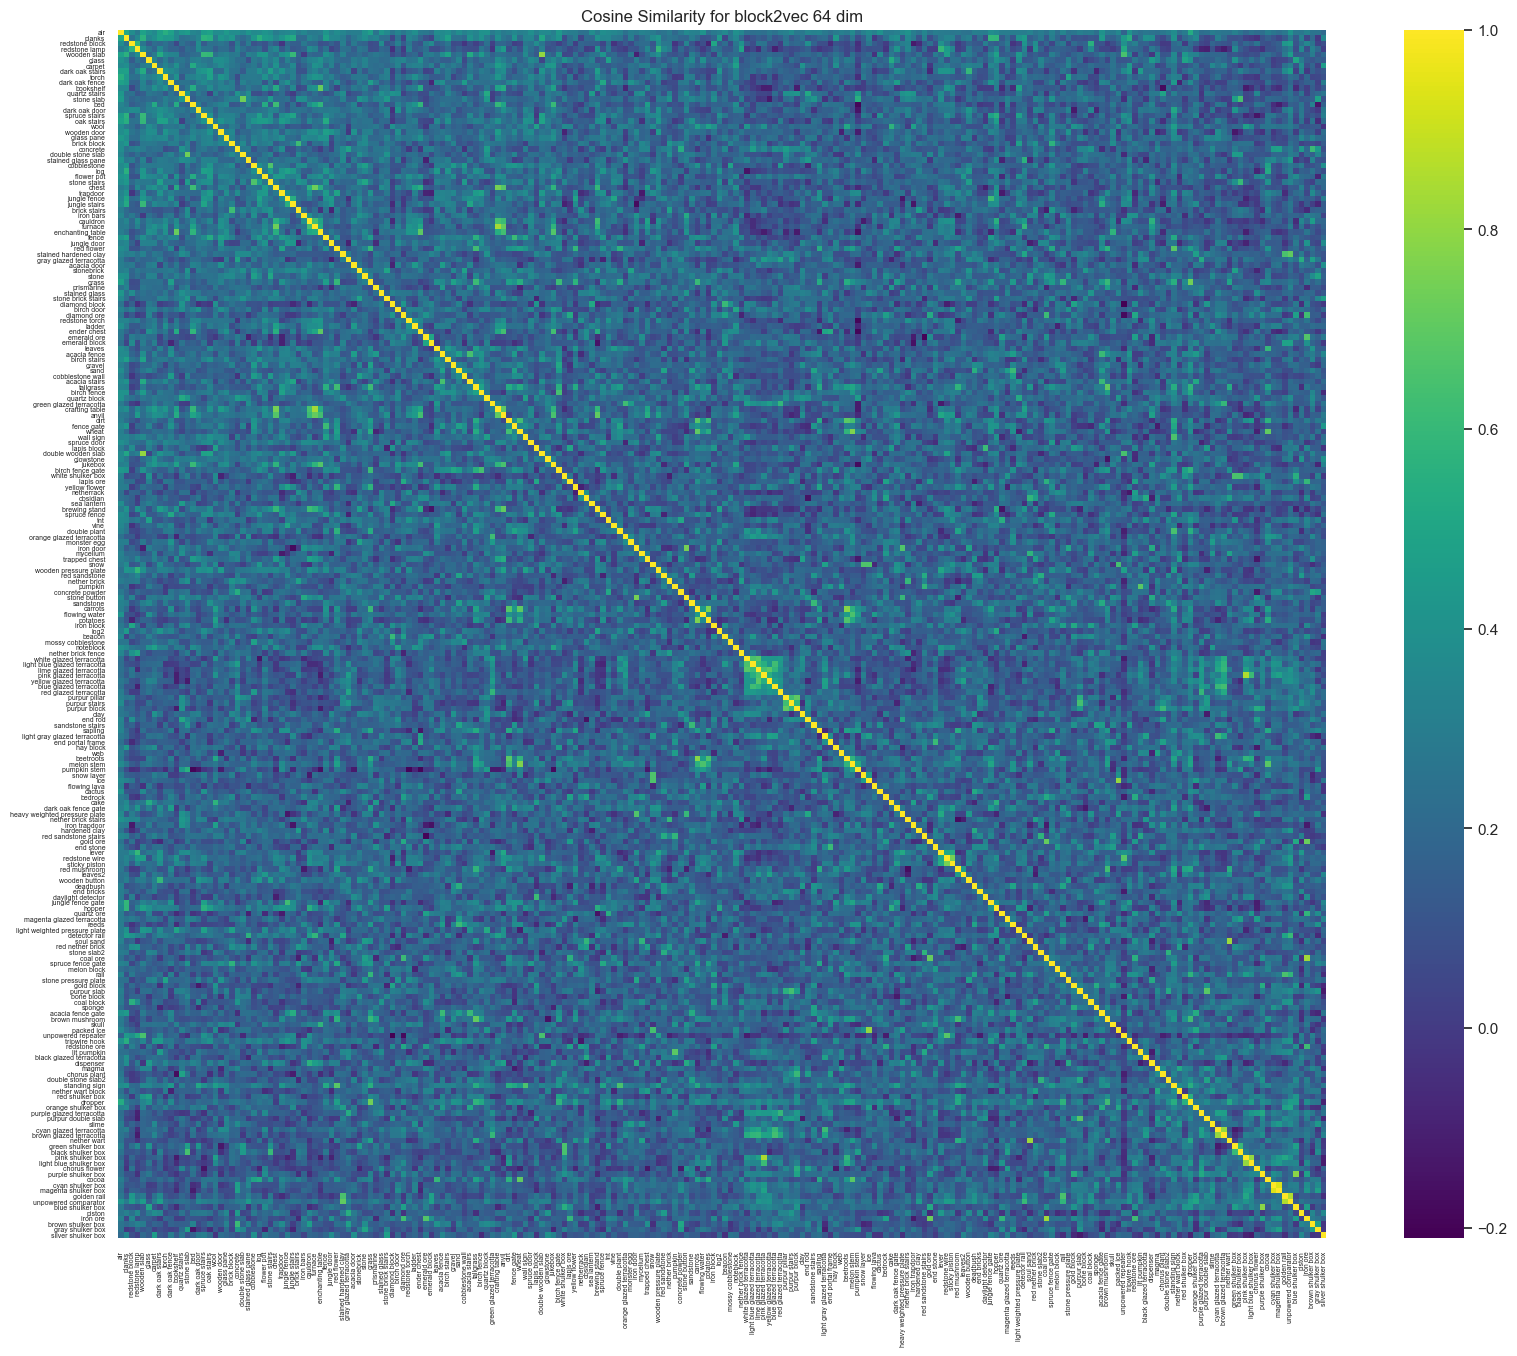

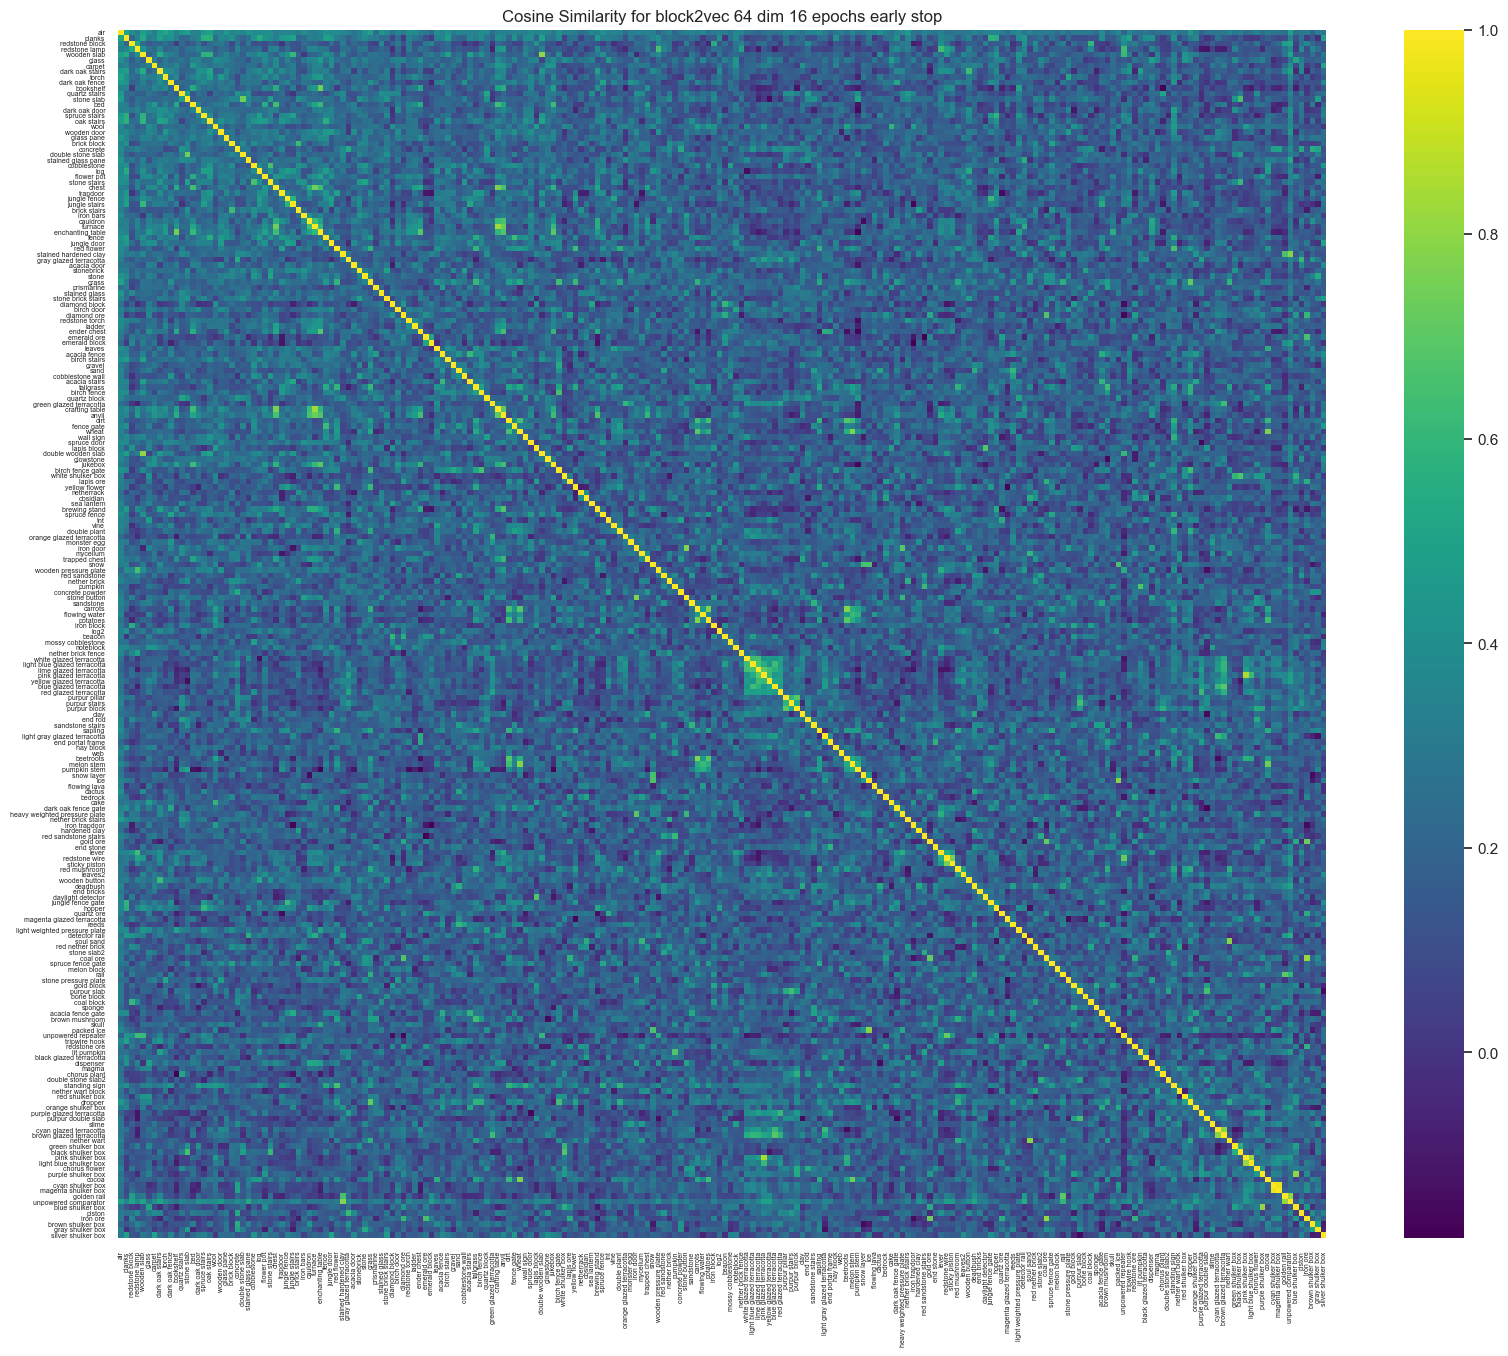

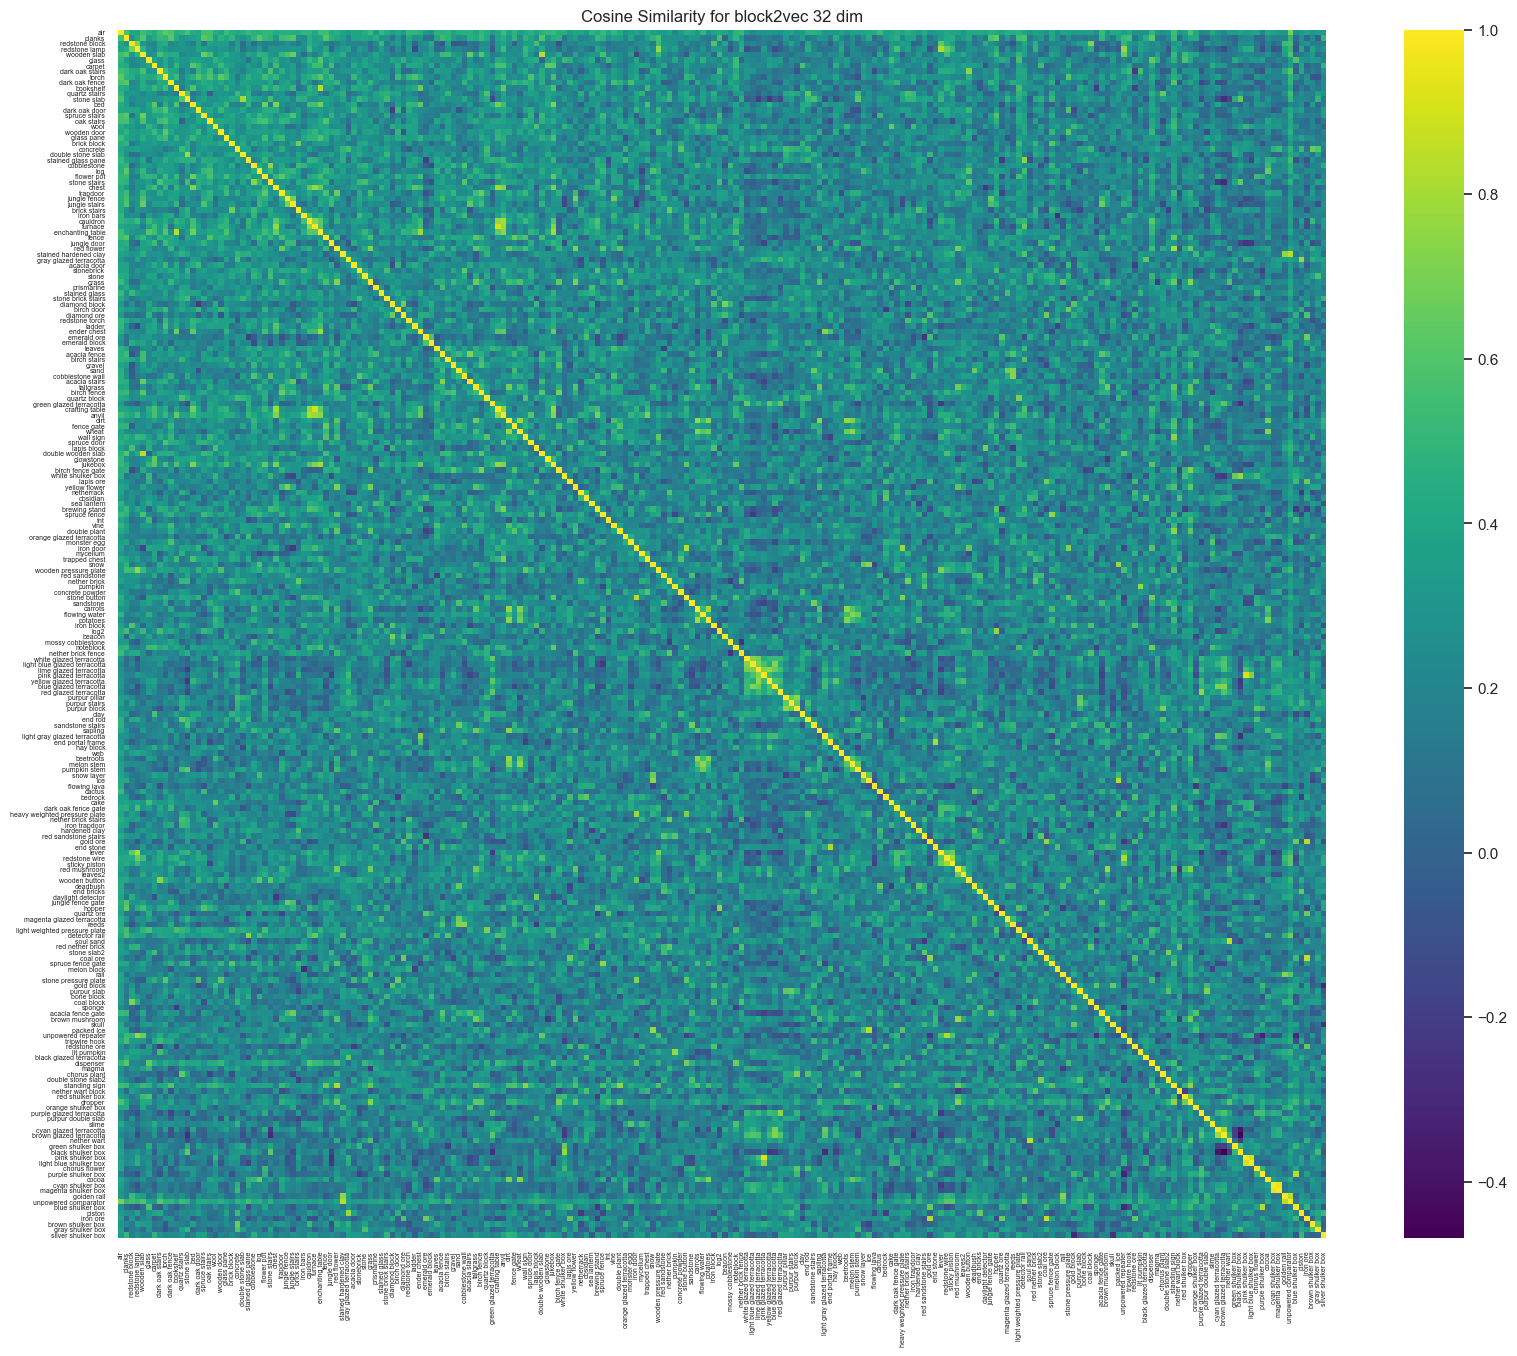

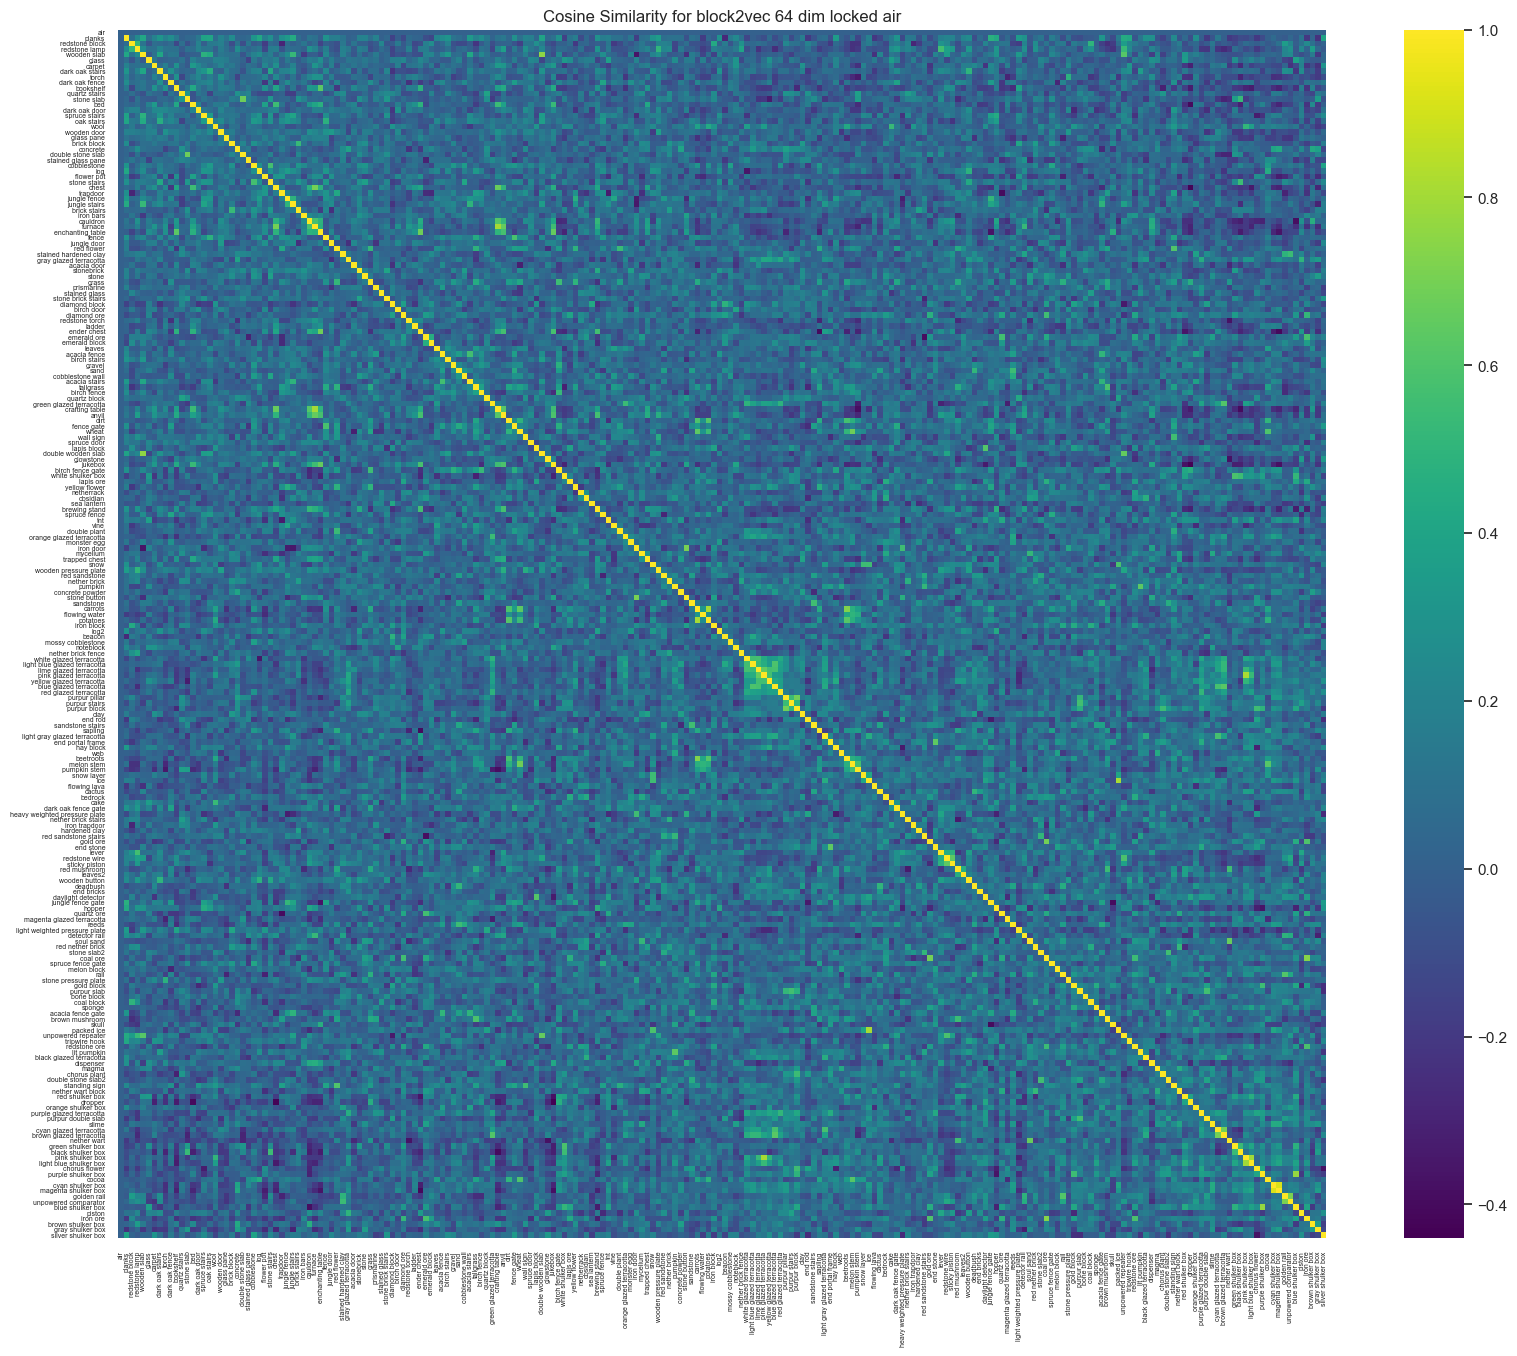

In [7]:
for folder in LIST_OUTPUT_FOLDERS:
    dir = OUTPUT_ROOT + folder
        
    names = []
    embeddings = np.load(dir + '/embeddings.npy')
    with open(dir + '/block2idx.pkl', 'rb') as f:
        block2idx = dict(pickle.load(f))
    with open(dir + '/idx2block.pkl', 'rb') as f:
        idx2block = dict(pickle.load(f))

    for i, b1 in idx2block.items():
        names.append(b1.replace('minecraft:', '').replace('_', ' '))
        
    matrix_dist = cosine_similarity(embeddings)

    fig = plt.figure(figsize=(20, 16))
    ax = sns.heatmap(matrix_dist, annot=False, square = True, cmap='viridis', xticklabels=names, yticklabels=names)
    ax.set_xticklabels(names, fontsize=5)
    ax.set_yticklabels(names, fontsize=5)
    ax.set_title("Cosine Similarity for " + folder)
    plt.show()

## Embedding 2D projection

Using Minimum-Distortion Embedding

In [8]:
import pymde
import numpy as np
import torch
import math
sns.set_theme()

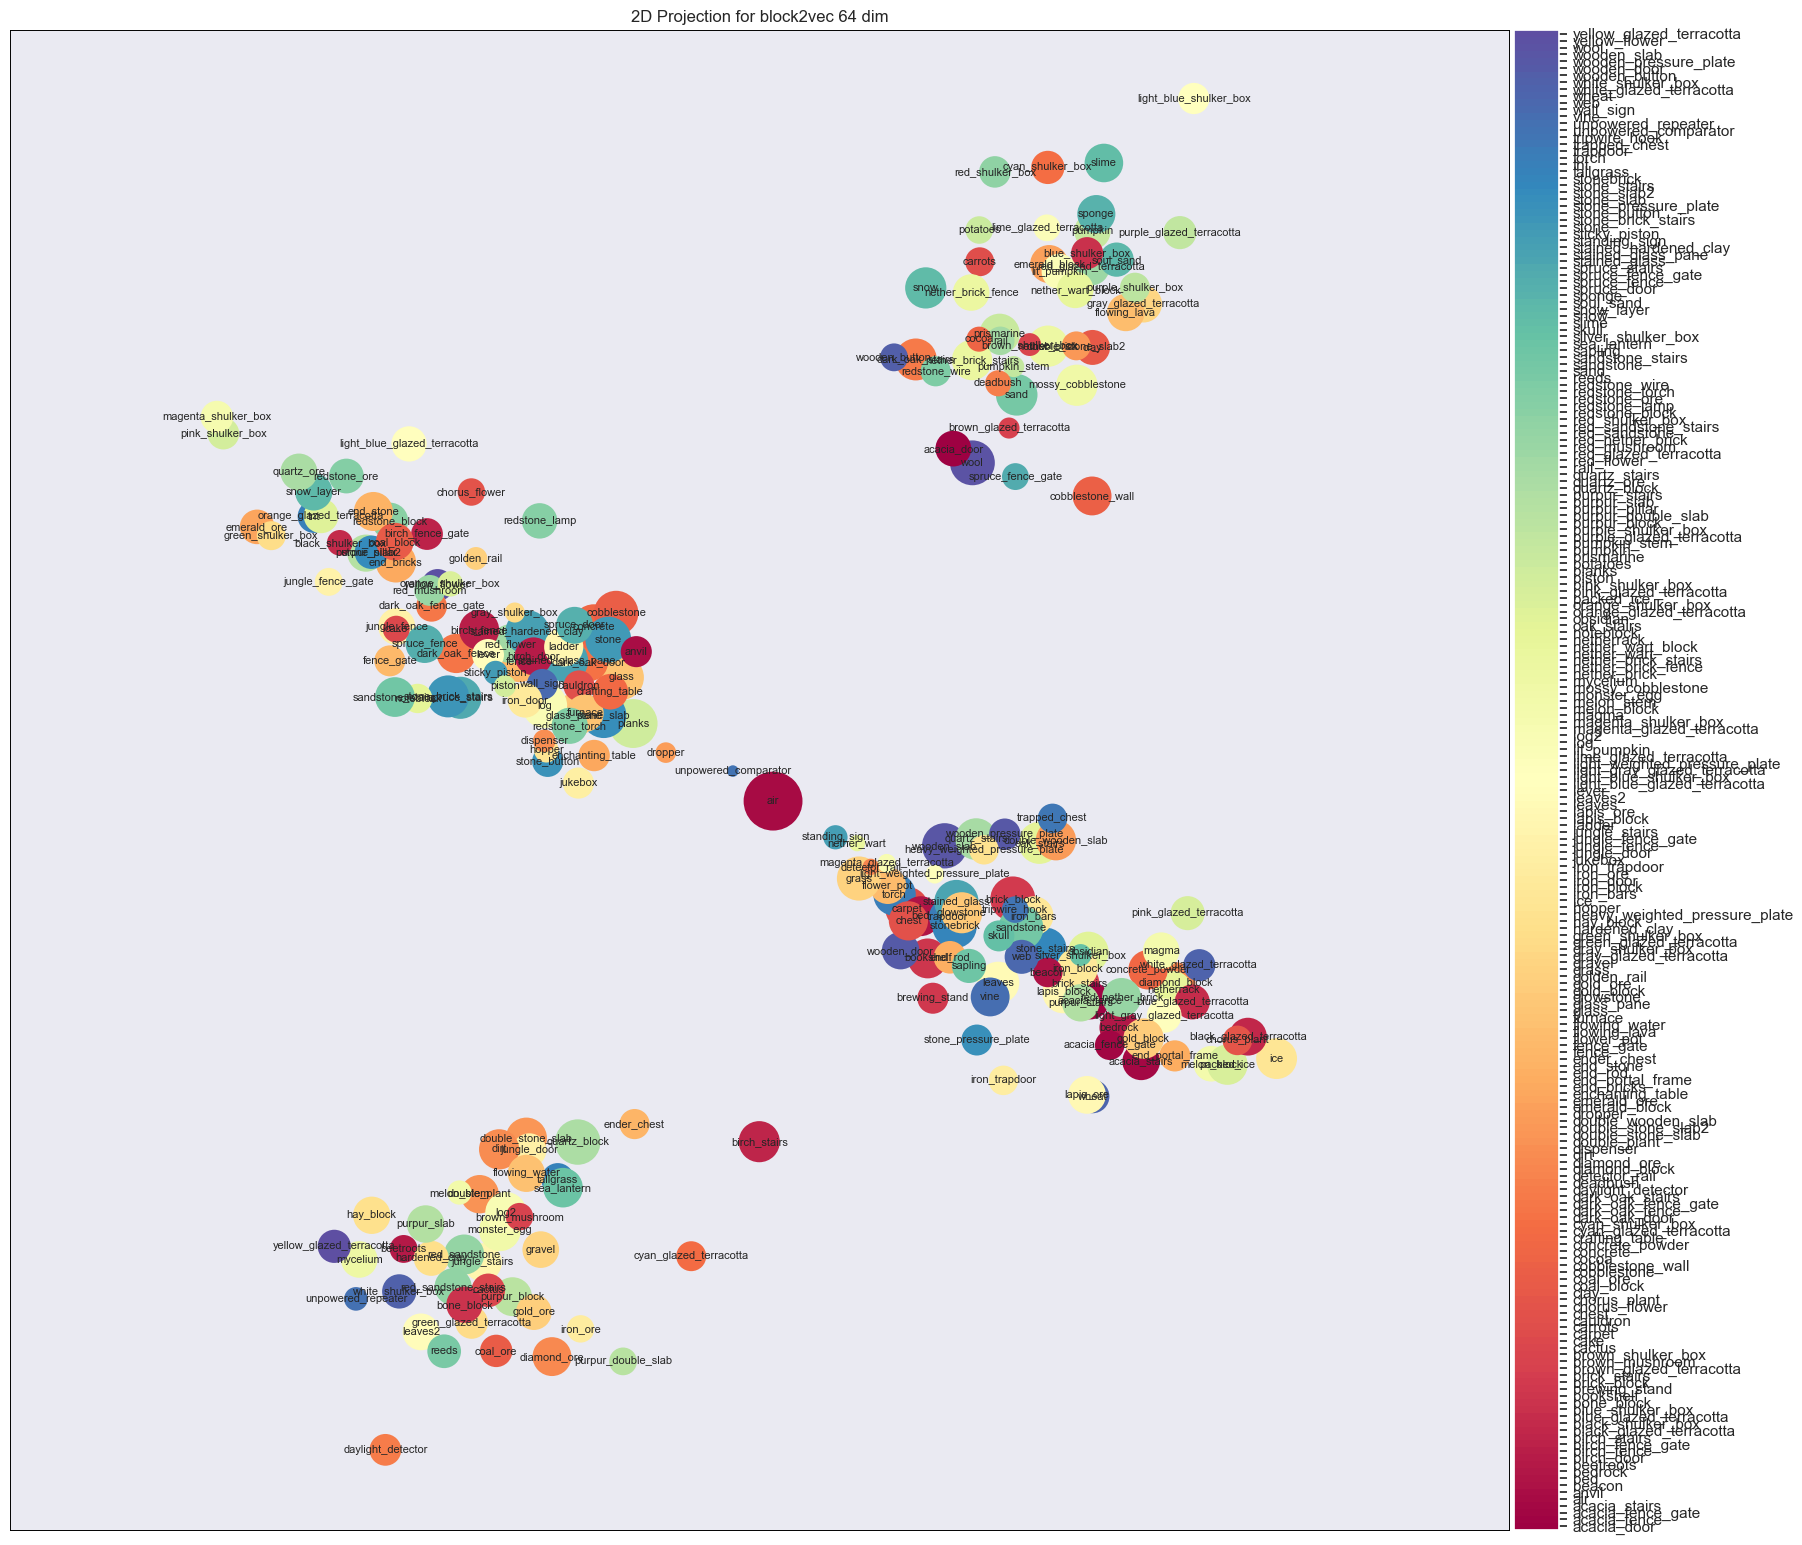

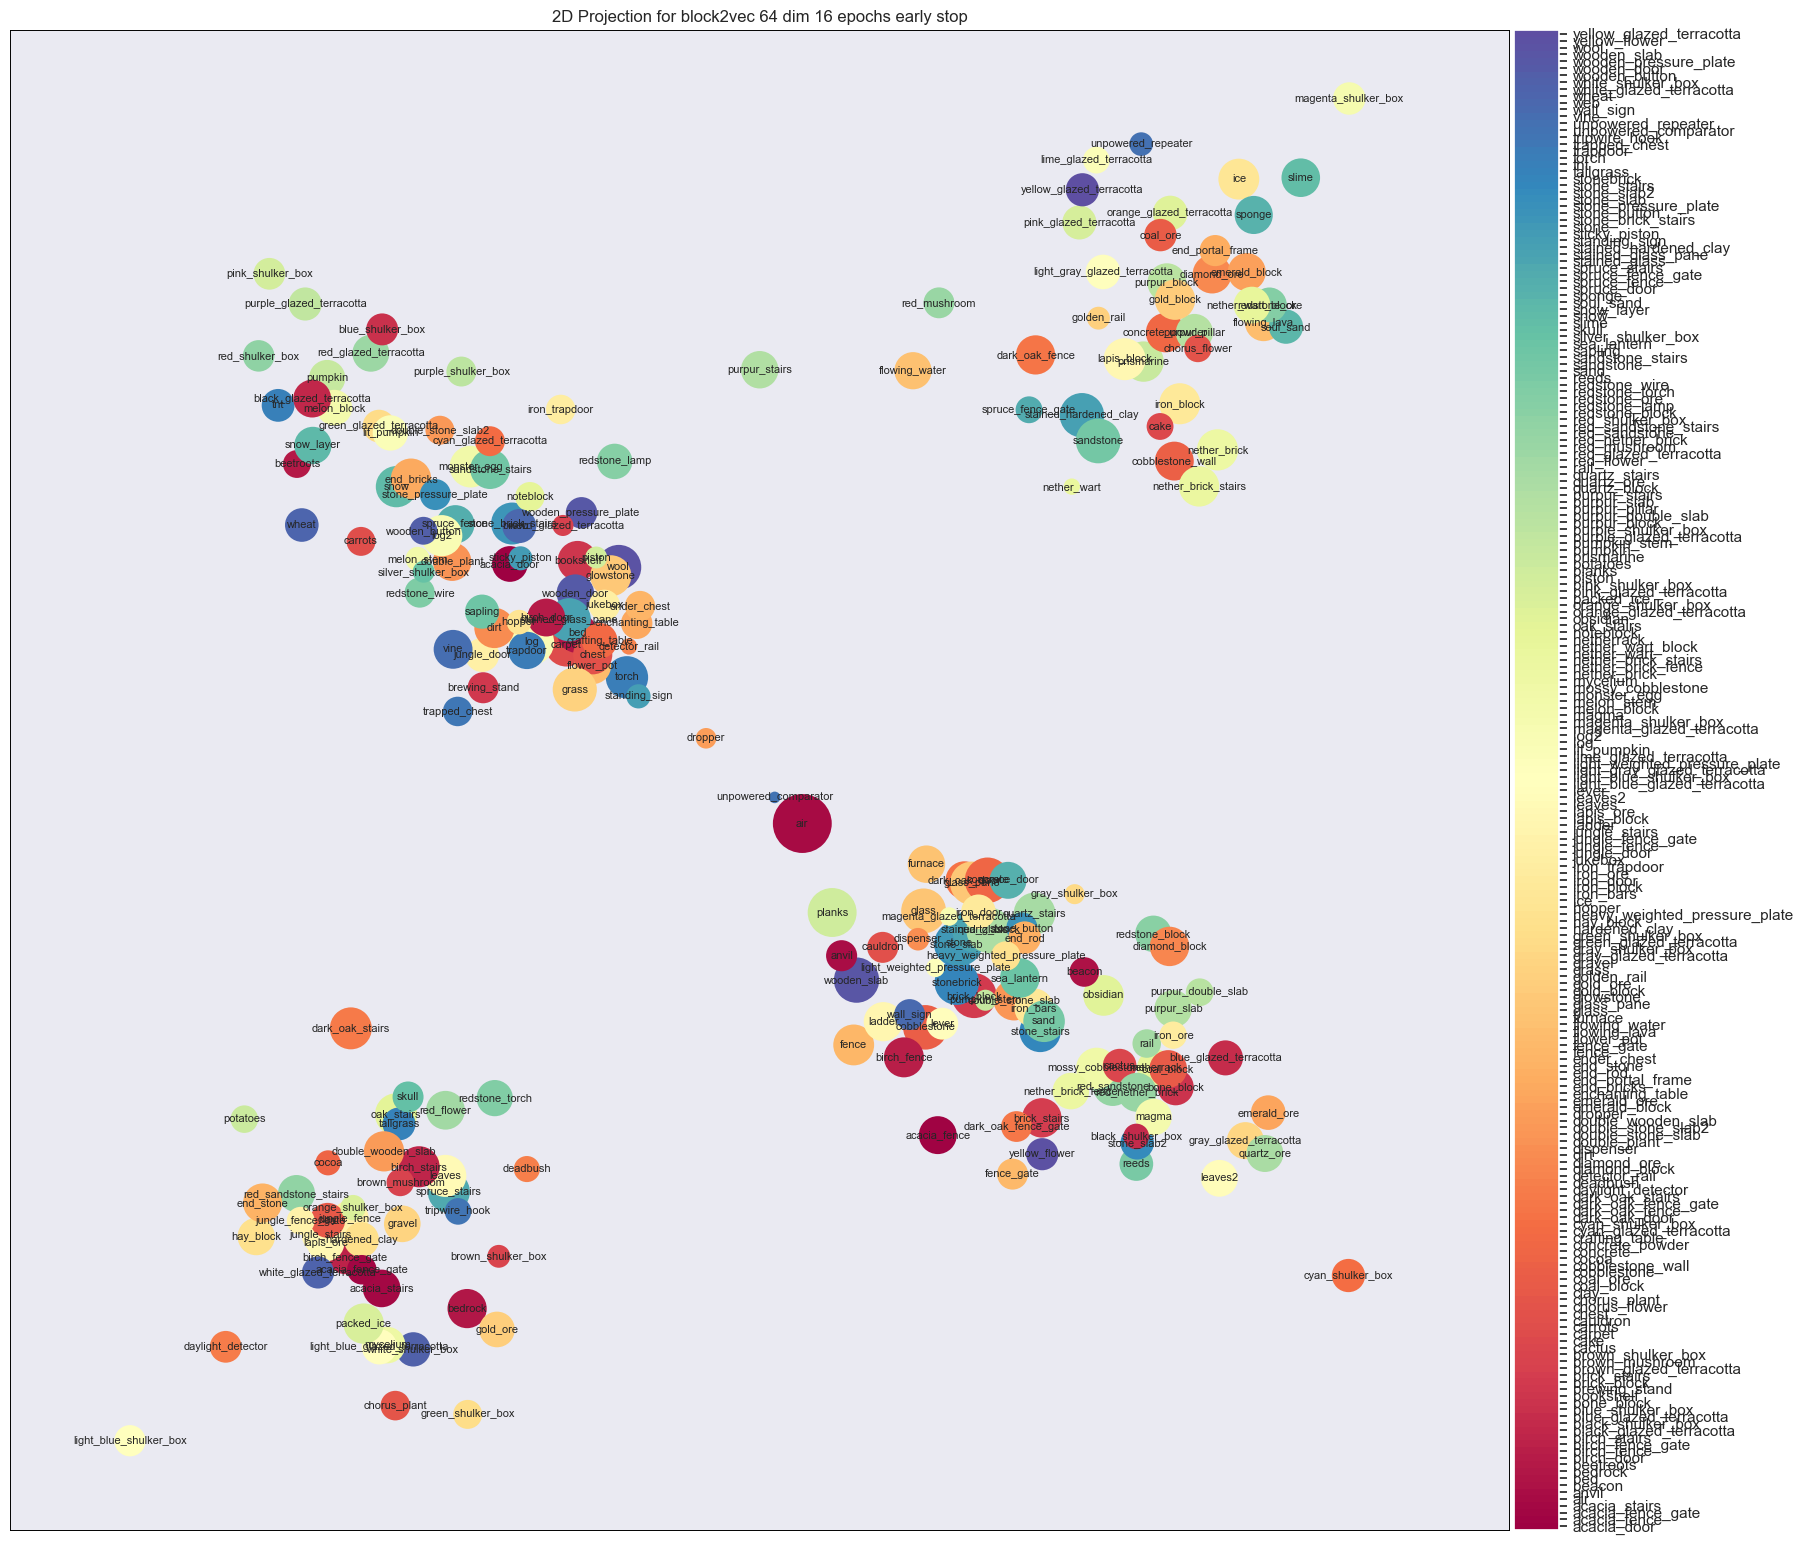

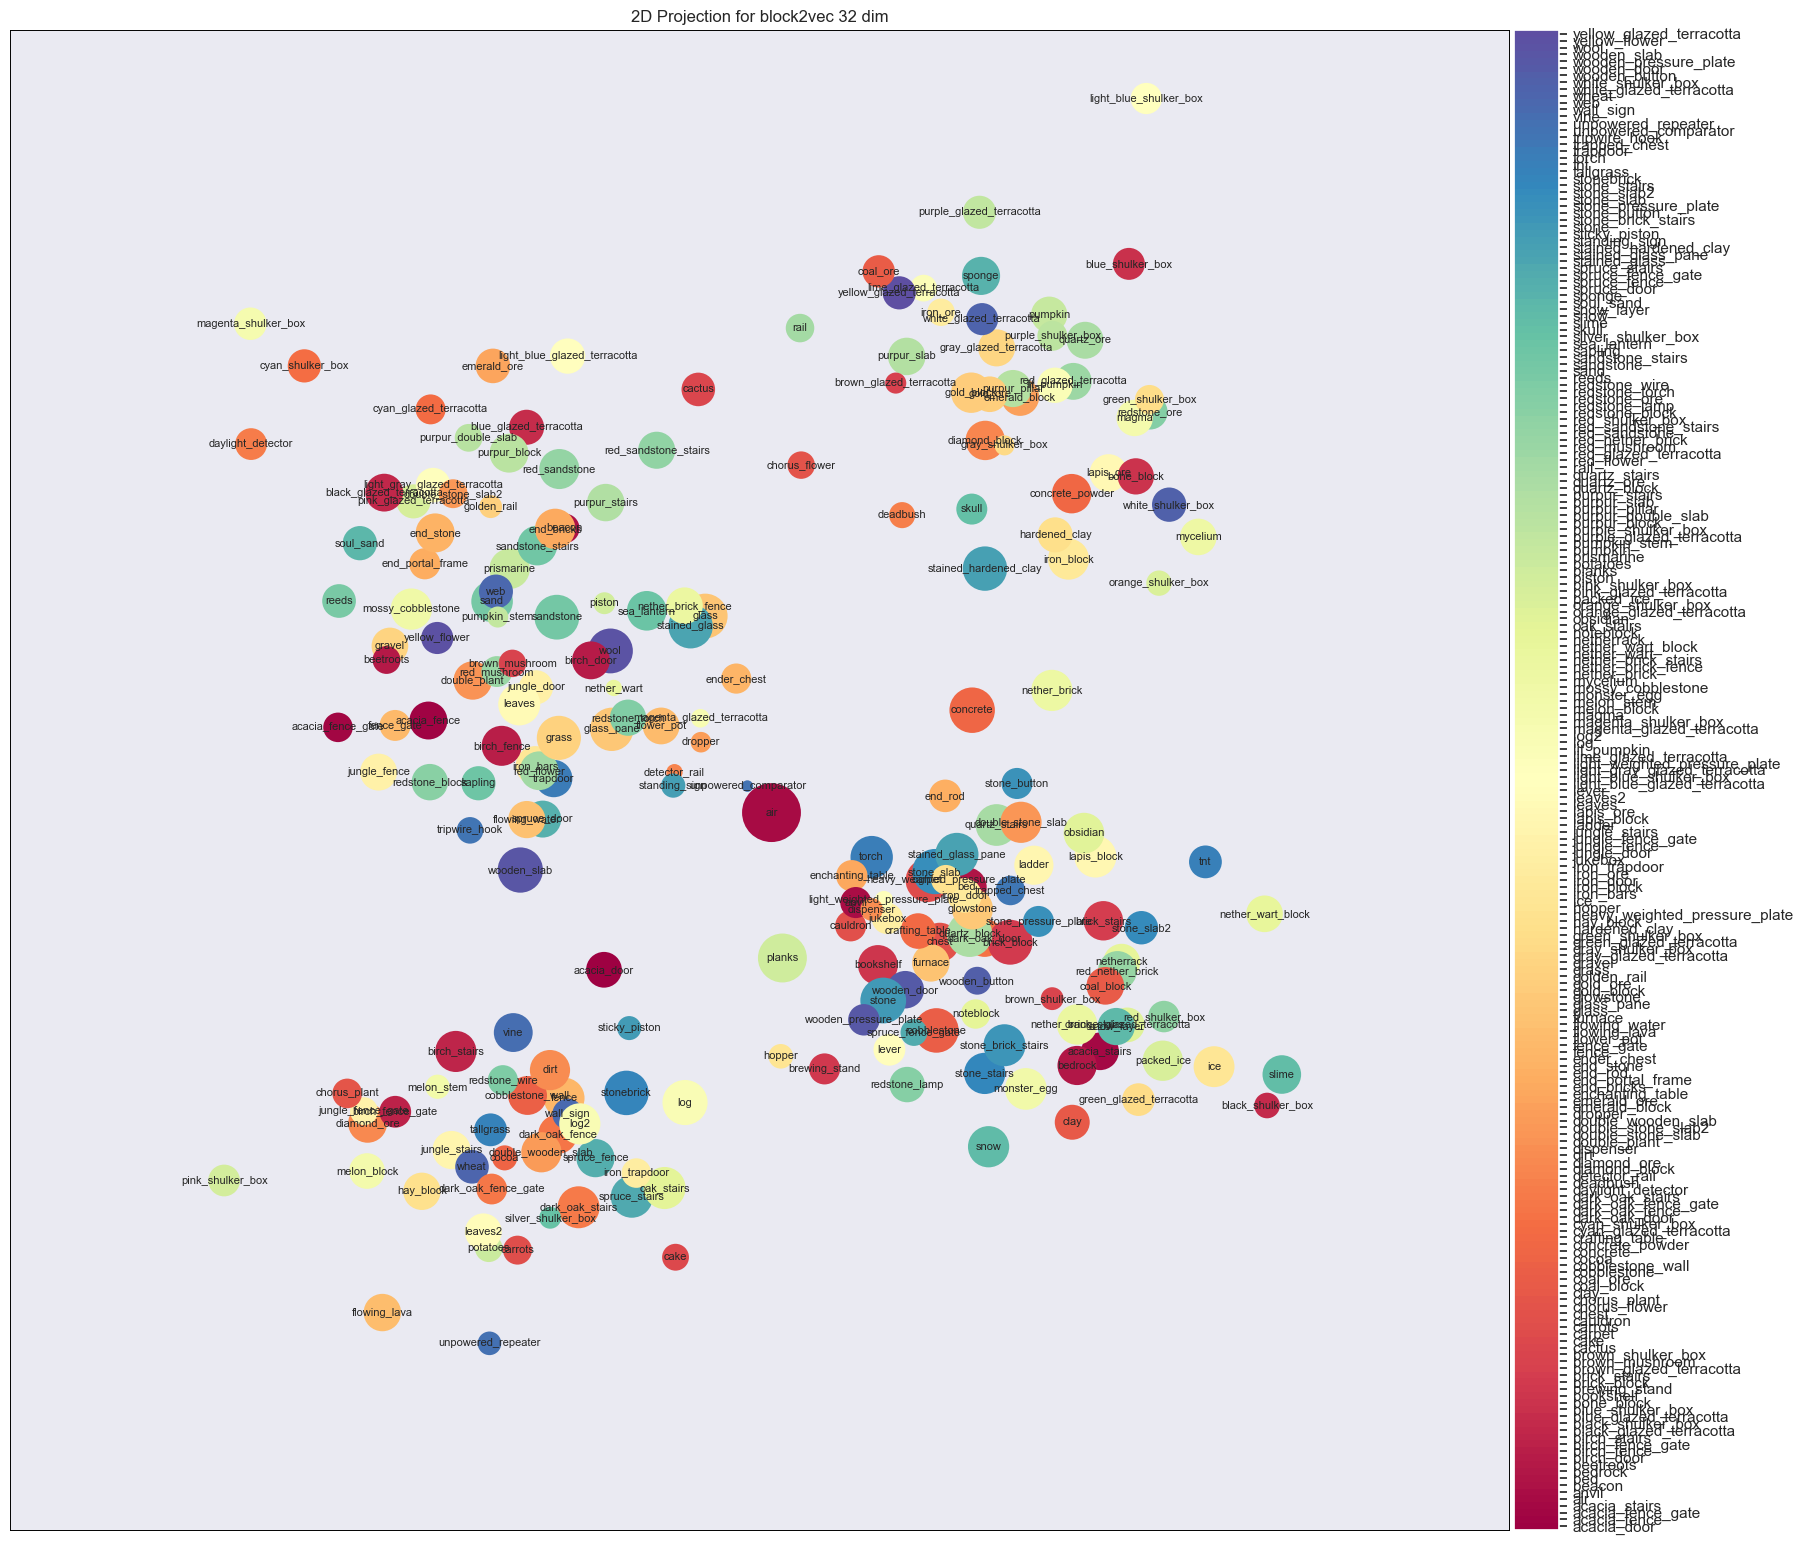

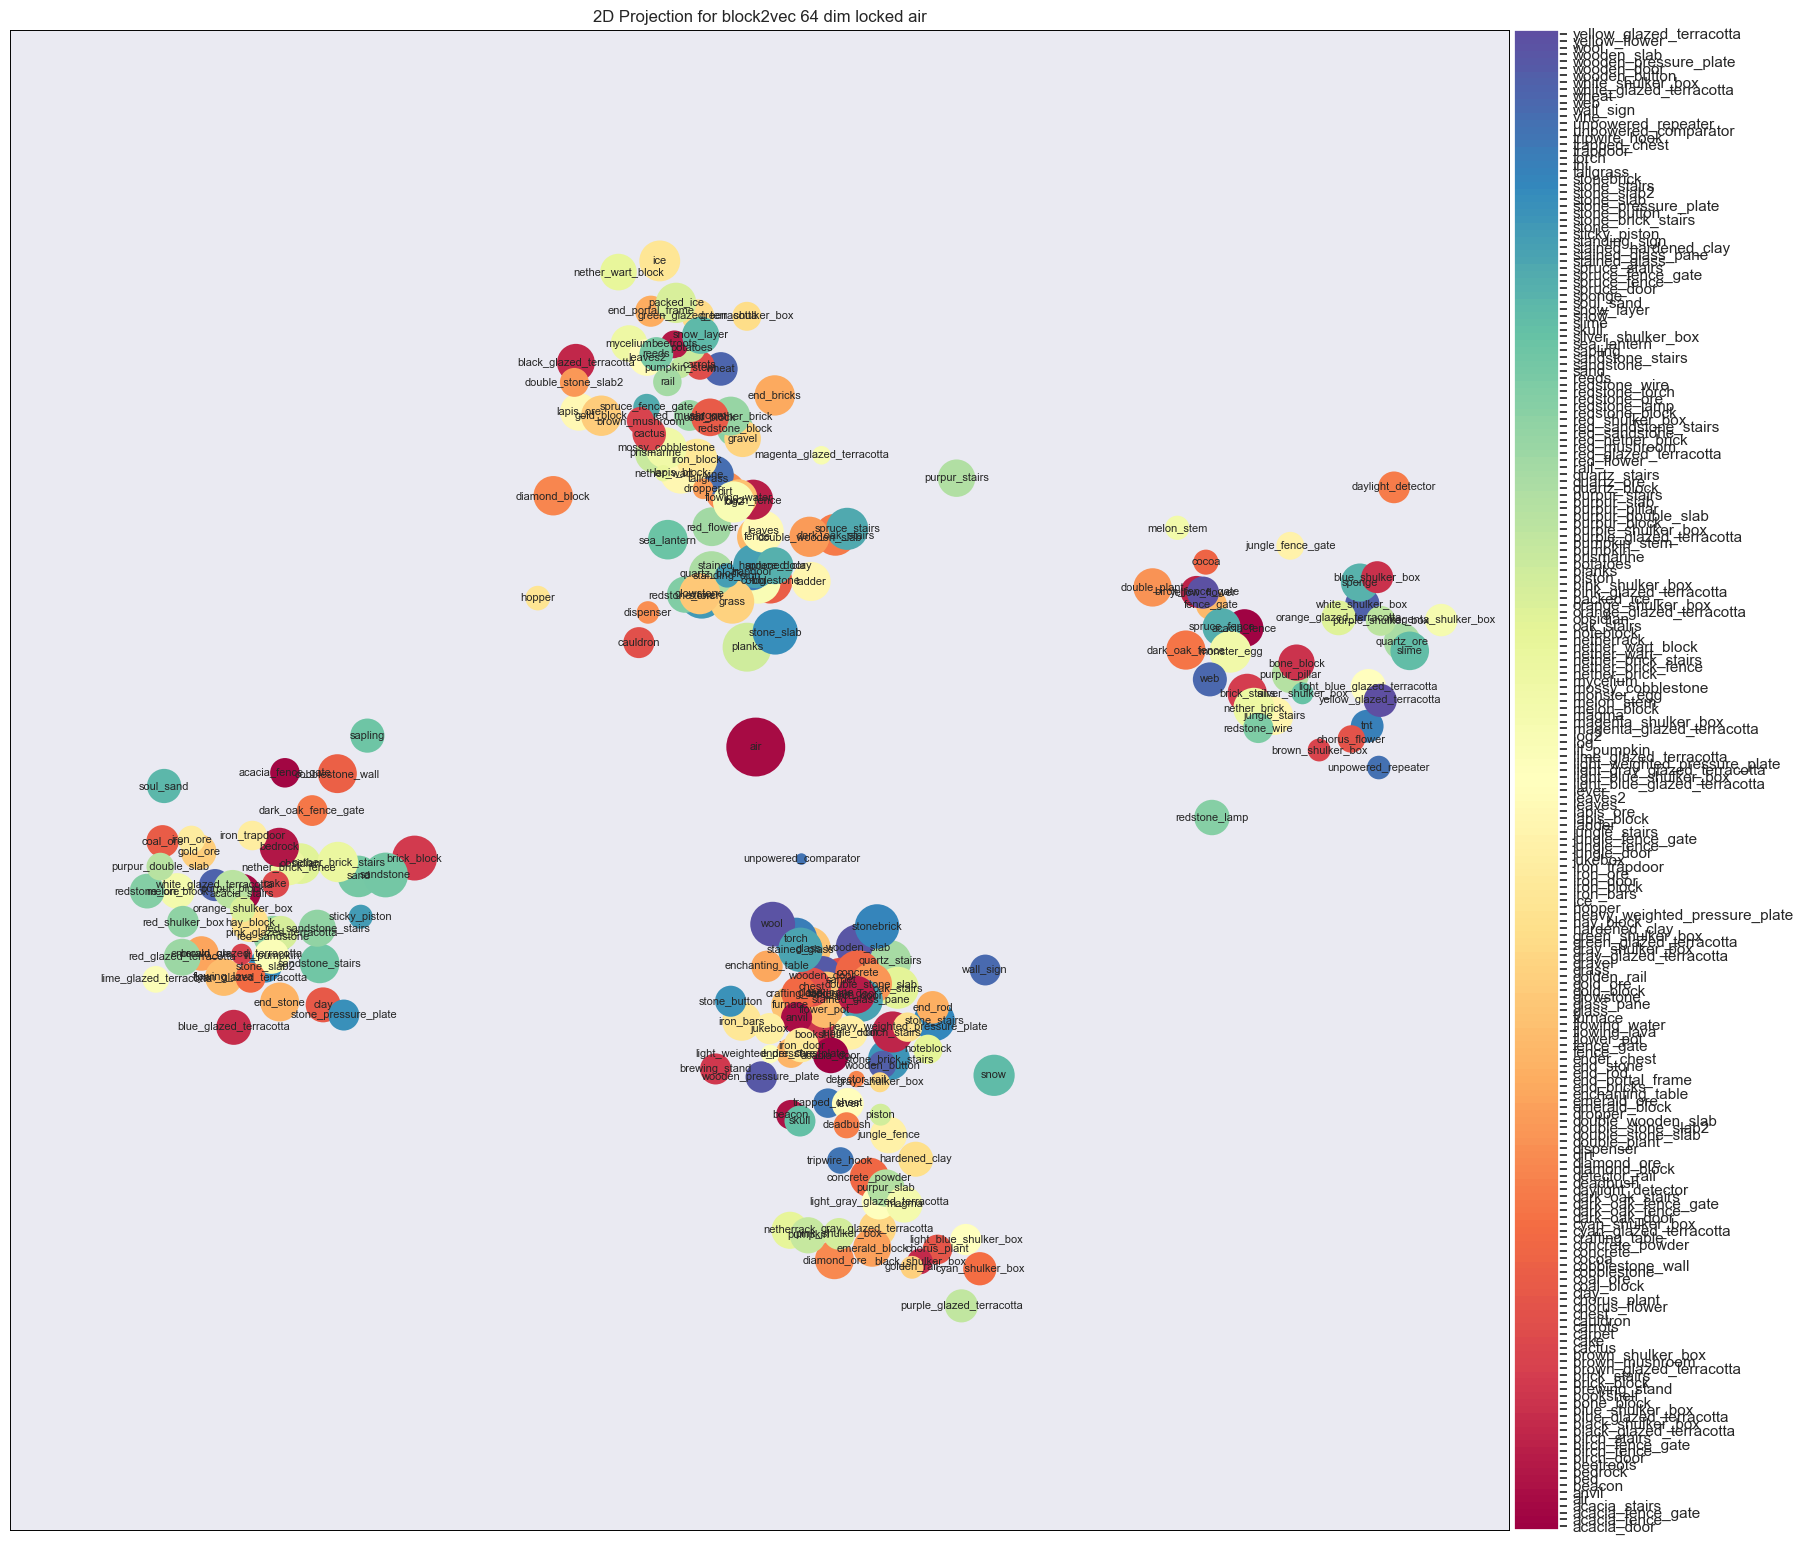

In [9]:
for folder in LIST_OUTPUT_FOLDERS:
    dir = OUTPUT_ROOT + folder

    embeddings = np.load(dir + '/embeddings.npy')

    embedding_2d_project = pymde.preserve_distances(torch.tensor(embeddings), embedding_dim=2).embed()
    labels = [str.split(":")[1] for str in list(block2idx.keys())]
    sizes = [math.log(block_frequency_dict["minecraft:" + label])*100 for label in labels]
    ax = pymde.plot(embedding_2d_project, marker_size=sizes, color_by=labels, figsize_inches=(16,16))
    ax.set_xticks([])
    ax.set_yticks([])
    for i, label in enumerate(labels):
        ax.text(embedding_2d_project.numpy().transpose().tolist()[0][i], embedding_2d_project.numpy().transpose().tolist()[1][i], label, ha='center', va='center', fontsize=8)
    ax.set_title("2D Projection for " + folder)

    plt.show()